In [8]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors, patches
import ants
import nibabel as nib
import os, urllib, zipfile

print(f'AntsPy version = {ants.__version__}')
#print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.5.3


In [9]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [10]:
def load_data(jsonData, dataFolderPath, training_or_test):
    images = []
    labels = []
    organs = []
    for sample in jsonData[training_or_test]:
        image_nib = nib.load(dataFolderPath + sample['image'].removeprefix('.'))
        image = image_nib.get_fdata()
        rot_image = np.rot90(image, k=1, axes=(0, 2))
        swapped_axis_img = np.swapaxes(rot_image, 1, 2)[:, :, :]
        antsImage = ants.from_numpy(swapped_axis_img)
        images.append(antsImage)
        label_nib = nib.load(dataFolderPath + sample['label'].removeprefix('.'))
        label = label_nib.get_fdata()
        rot_label = np.rot90(label, k=1, axes=(0, 2))
        swapped_axis_label = np.swapaxes(rot_label, 1, 2)[:, :, :]
        antsLabel = ants.from_numpy(swapped_axis_label)
        labels.append(antsLabel)
        organ = np.full_like(swapped_axis_img, fill_value=np.min(swapped_axis_img), dtype=np.float32)
        organ[swapped_axis_label > 0] = swapped_axis_img[swapped_axis_label > 0]
        antsOrgan = ants.from_numpy(organ)
        organs.append(antsOrgan)

    return images, labels, organs

In [11]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './AbdomenCTCT'
training_images_raw, training_labels_raw, training_organs_raw = load_data(data_json, dataFolder, 'training')

In [12]:
len(training_images_raw)

30

In [13]:
training_labels_raw[0]

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 192, 160)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [14]:
training_images_raw[0]

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 192, 160)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [15]:
training_organs_raw[0]

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 192, 160)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [16]:
np.min(training_organs_raw[0].numpy())

-1024.0

In [17]:
np.max(training_images_raw[0].numpy())

1841.9026

In [18]:
np.max(training_organs_raw[0].numpy())

1016.83264

(-0.5, 191.5, 255.5, -0.5)

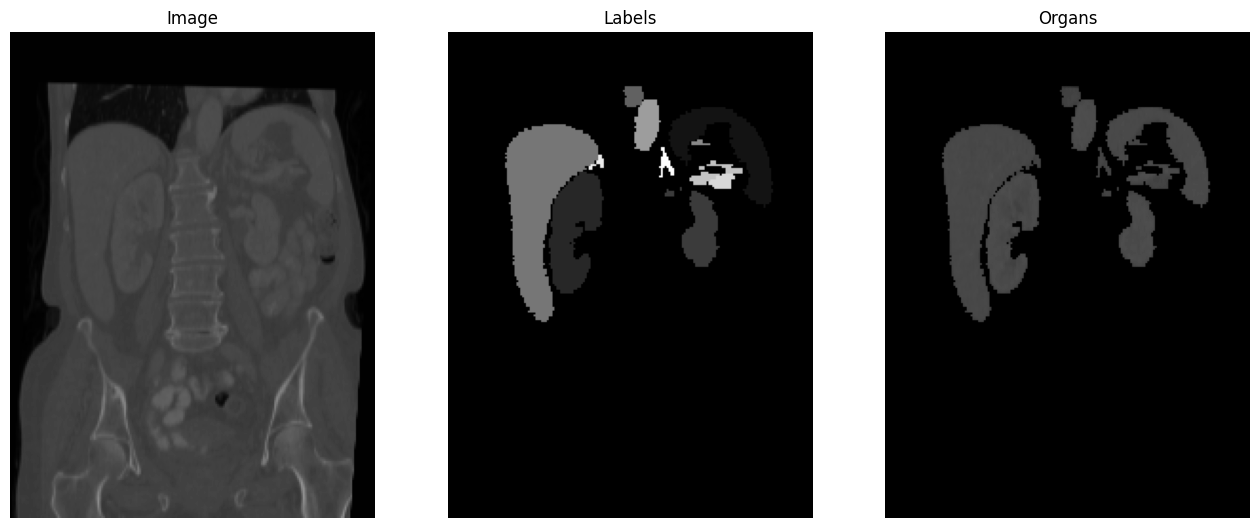

In [24]:
# preview data
img = 0
depth = 70

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 8))
ax0.imshow(training_images_raw[img].numpy()[:, :, depth], cmap='gray', vmin=-1024, vmax=3071)
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(training_labels_raw[img].numpy()[:, :, depth], cmap='gray')
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(training_organs_raw[img].numpy()[:, :, depth], cmap='gray', vmin=-1024, vmax=3071)
ax2.set_title("Organs")
ax2.axis("off")

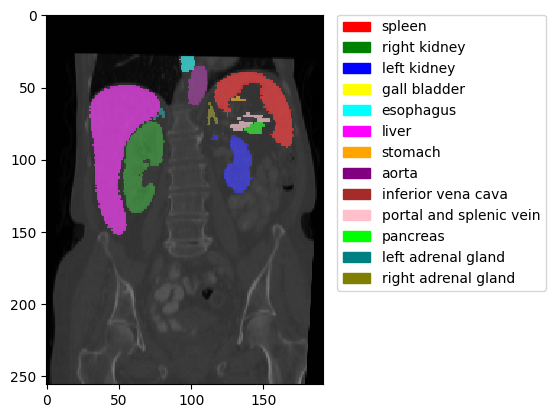

In [25]:
# Setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# View image
plt.imshow(training_images_raw[img].numpy()[:, :, depth], cmap='gray', interpolation='none')

# View colors
plt.imshow(training_labels_raw[img].numpy()[:, :, depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# Setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# View rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# View legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [26]:
print(training_images_raw[img].shape)
print(training_labels_raw[img].shape)
print(training_organs_raw[img].shape)

(256, 192, 160)
(256, 192, 160)
(256, 192, 160)


In [27]:
# Load your fixed and moving images
fixed_image = training_organs_raw[img + 5]
moving_image = training_organs_raw[img]

In [28]:
registration = ants.registration(
    fixed=fixed_image,
    moving=moving_image,
    type_of_transform='SyNRA',
    aff_metric='mattes',
    aff_sampling=32,
    verbose=True
)

antsRegistration -d 3 -r [000002489832FA48,000002489827BFE8,1] -m mattes[000002489832FA48,000002489827BFE8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[000002489832FA48,000002489827BFE8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[000002489832FA48,000002489827BFE8,1,32] -t SyN[0.200000,3.000000,0.000000] -c [40x20x0,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [C:\Users\Tilmann\AppData\Local\Temp\tmp6wc9bxpg,000002489832FD08,000002489832F708] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1


In [ ]:
print(registration)

In [ ]:
registered_img_ants = registration['warpedmovout']
plt.imshow(registered_img_ants.numpy()[:, :, depth], cmap='gray')

In [ ]:
# preview data

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 8))
ax0.imshow(training_organs_raw[img + 5].numpy()[:, :, depth], cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(training_organs_raw[img].numpy()[:, :, depth], cmap='gray')
ax1.set_title("Moving")
ax1.axis("off")
ax2.imshow(registered_img_ants.numpy()[:, :, depth], cmap='gray')
ax2.set_title("Moved")
ax2.axis("off")
ax3.imshow(training_organs_raw[img + 5].numpy()[:, :, depth], cmap='gray')
ax3.imshow(registered_img_ants.numpy()[:, :, depth], alpha=0.3, cmap='Reds')
ax3.set_title("Both")
ax3.axis("off")

In [ ]:
# Access the transformation matrix or deformation field
transformation = registration['fwdtransforms'][0]  # Forward transformation

In [ ]:
# Apply the transformation to the moving image
warped_image = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation)


In [ ]:
# Convert images to numpy arrays for visualization
fixed_np = fixed_image.numpy()
warped_np = warped_image.numpy()

# Display fixed and warped images side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(fixed_np[:, :, depth], cmap='gray')
axes[0].set_title('Fixed Image')
axes[0].axis('off')

axes[1].imshow(warped_np[:, :, depth], cmap='gray')
axes[1].set_title('Warped (Registered) Image')
axes[1].axis('off')

plt.show()


In [ ]:
# Load the displacement field (transformation field)
displacement_field = ants.image_read(transformation)


In [ ]:
# Assume the displacement field is 3D with 3 components
displacement_field_np = displacement_field.numpy()

# Extract a 2D slice (e.g., middle slice)
x_displacement = displacement_field_np[:, :, depth, 0]
y_displacement = displacement_field_np[:, :, depth, 1]

# Generate a grid of coordinates
x, y = np.meshgrid(np.arange(x_displacement.shape[1]), np.arange(x_displacement.shape[0]))

# Create a quiver plot
plt.figure(figsize=(10, 10))
plt.quiver(x, y, x_displacement, y_displacement, scale=1, scale_units='xy', angles='xy')
plt.title("Quiver Plot of Displacement Field")
plt.gca().invert_yaxis()  # To match image coordinate system
plt.show()